# Chess tracking

In this notebook full detection process with necessary utility functions is present

## Imports

In [1]:
import cv2
import PIL
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cairosvg
import io
import os
import shutil

from ipywidgets import Video, widgets
from IPython.display import display
import chess
import chess.svg
%matplotlib inline

### Setting imshow function

In [2]:
if "google.colab" in str(get_ipython()):
    from google.colab.patches import cv2_imshow

    imshow = cv2_imshow
else:

    def imshow(img):
        img = img.clip(0, 255).astype("uint8")
        if img.ndim == 3:
            if img.shape[2] == 4:
                img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA)
            else:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        display(PIL.Image.fromarray(img))

## Utility functions

In [3]:
# Resize img helper
def resize_img(img, div=3):
    return cv2.resize(img, (img.shape[1]//div, img.shape[0]//div))

# Utility for getting first video frame
def save_first_frame(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Check if the video opened successfully
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    # Read the first frame
    ret, frame = cap.read()

    # Check if the frame was read successfully
    if not ret:
        print("Error: Could not read the first frame.")
        return

    # Release the video capture object
    cap.release()

    return frame

def find_closest_points_to_corners(points, corners):
    closest_points = []
    for corner in corners:
        distances = np.linalg.norm(points - corner, axis=1)
        closest_point_index = np.argmin(distances)
        closest_points.append(points[closest_point_index])
    return np.array(closest_points)

# Camera calibration utility calculating most likely chessboard corner points
def get_closest_corners(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (7, 7), 0)

    dst = cv2.cornerHarris(blurred, 7, 3, 0.0)
    dst = cv2.dilate(dst, np.ones((7,7)))
    corners = np.argwhere(dst > 0.005 * dst.max())

    # Find corners closest to image corners
    image_corners = np.array([[0, 0], [0, frame.shape[1]], [frame.shape[0], 0], [frame.shape[0], frame.shape[1]]])
    closest_corners = find_closest_points_to_corners(corners, image_corners)

    return closest_corners

# Getting homography matrix calculation target points
def get_target_points(target_square_size=1000):
    target_points = np.array([[0, 0], [0, target_square_size - 1], [target_square_size - 1, 0], [target_square_size - 1, target_square_size - 1]], dtype=np.float32)
    return target_points

# Calculating difference in distance of a corners' position between frames
def get_corner_diff(ref_corners, new_corners):
    ref_corners = np.array(ref_corners)
    new_corners = np.array(new_corners)

    distances = np.linalg.norm(ref_corners - new_corners, axis=1)
    
    return distances

# Algorithm managing correcting corners' position
def correct_corners(corners, ref_corners, marked_change):
    updated_corners = corners.copy()
    good_corners = [(corner, id) for id, corner in enumerate(corners) if not marked_change[id]]
    bad_corners = [(corner, id) for id, corner in enumerate(corners) if marked_change[id]]

    num_incorrect = len(bad_corners)
    
    # If all corners are withing distance threshold, return new corners
    if num_incorrect == 0:
        return corners
    # If all corners are incorrect, return previous frame's corners
    if num_incorrect == 4:
        return ref_corners
    
    good_corner, g_id = good_corners[-1]
    
    # Calculate distance between bad and good corner in previous frame and apply it to find new corrected position
    for _, b_id in bad_corners:
        delta_x = ref_corners[b_id][0] - ref_corners[g_id][0]
        delta_y = ref_corners[b_id][1] - ref_corners[g_id][1]

        # Update the position of the faulty corner based on the difference
        updated_corners[b_id][0] = good_corner[0] + delta_x
        updated_corners[b_id][1] = good_corner[1] + delta_y
        
    return updated_corners

# Annotates chess pieces
def display_moves(frame, chessboard_state, grid_division):
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.75
    thickness = 2
    
    for i in range(len(grid_division[:-1])):
        for j in range(len(grid_division[:-1])):        
            cv2.putText(frame, chessboard_state[i][j],  (grid_division[j]+16, grid_division[7-i]+60), font, font_scale, (0, 0, 255), thickness)

# Displays events
def display_events(frame, events_queue, display_hand):
    cv2.putText(frame, f'Events:', (1010, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    if display_hand > 0:
        cv2.putText(frame, f'Hand present', (1040, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    skip = 0
    remove_list = []
    for event in events_queue:
        if event[1] > 0:
            skip += 1
            event[1] -= 1
            cv2.putText(frame, f'{event[0]}', (1040, 100 + skip*60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        else:
            remove_list.append(event)
    
    for x in remove_list:
        events_queue.remove(x)

In [4]:
# Checks occupation of spaces in a new frame
def get_board_color_state(calibrated_image, grid_division, total_white, total_black, update_mask_thresholds=False):
    detected_figures = [[0,0,0,0,0,0,0,0] for i in range(8)]
    img_rgb = cv2.cvtColor(calibrated_image, cv2.COLOR_BGR2RGB)

    # For easy and medium-difficulty data
    if not update_mask_thresholds:
        lower_blue = np.array([50, 95, 155], dtype=np.uint8)
        upper_blue = np.array([100, 150, 170], dtype=np.uint8)

        lower_pink = np.array([200, 100, 160], dtype=np.uint8)
        upper_pink = np.array([230, 170, 200], dtype=np.uint8)
    # For hard-difficulty data
    else:
        lower_blue = np.array([50, 105, 155], dtype=np.uint8)
        upper_blue = np.array([120, 170, 190], dtype=np.uint8)
        
        lower_pink = np.array([210, 120, 180], dtype=np.uint8)
        upper_pink = np.array([250, 195, 220], dtype=np.uint8)

    mask_lb = cv2.inRange(img_rgb, lower_blue, upper_blue)
    mask_p = cv2.inRange(img_rgb, lower_pink, upper_pink)
    kernel1 = np.ones((3, 3), np.uint8)
    kernel2 = np.ones((7, 7), np.uint8)

    dilated_mask_lb = cv2.dilate(mask_lb, kernel1, iterations=2)
    closed_mask_lb = cv2.morphologyEx(dilated_mask_lb, cv2.MORPH_CLOSE, kernel2)
    bin_mask_lb = np.where(closed_mask_lb==255, 1, 0)

    dilated_mask_p = cv2.dilate(mask_p, kernel1, iterations=2)
    closed_mask_p = cv2.morphologyEx(dilated_mask_p, cv2.MORPH_CLOSE, kernel2)
    bin_mask_p = np.where(closed_mask_p==255, 1, 0)
    
    count_white = 0
    count_black = 0
    for i in range(len(grid_division[:-1])):
        for j in range(len(grid_division[:-1])):
            # Get a chessboard square (omit some margin to avoid overstepping figures)
            square_lb = bin_mask_lb[grid_division[i]+10:grid_division[i+1]-10, grid_division[j]+10:grid_division[j+1]-10]
            square_p = bin_mask_p[grid_division[i]+10:grid_division[i+1]-10, grid_division[j]+10:grid_division[j+1]-10]
            
            # Higher margin for hard-difficulty problem
            if update_mask_thresholds:
                des = 15
                square_lb = bin_mask_lb[grid_division[i]+des:grid_division[i+1]-des, grid_division[j]+des:grid_division[j+1]-des]
                square_p = bin_mask_p[grid_division[i]+des:grid_division[i+1]-des, grid_division[j]+des:grid_division[j+1]-des]
            
            if np.any(square_lb==1):
                detected_figures[7-i][j] = -1
                count_white += 1
                
            if np.any(square_p==1):
                detected_figures[7-i][j] = 1
                count_black += 1
    
    # -1 to account for figure capture
    if (count_black == total_black or count_black == total_black-1) and \
        (count_white == total_white or count_white == total_white-1):
        return detected_figures
    
    # If failed return None, assume it's presence of a hand
    return None

In [5]:
# Algorithm for checking if and what kinf of a move happened between detected states, updates chessboard state, reduces figure counts in case of an attack, updates events queue
def detect_moves(prev_color_state, new_color_state, chessboard_state, white_turn, board, total_white_figures, total_black_figures, events_queue, show_board=True):
    spaces_alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
    disappeared = []
    appeared = []
    attacked = []
    reduce_white = False
    reduce_black = False
    for i in range(len(prev_color_state)):
        for j in range(len(prev_color_state)):
            # No change
            if prev_color_state[i][j] == new_color_state[i][j]:
                continue
            
            # Figure appeared on empty square
            elif prev_color_state[i][j] == 0:
                appeared.append(spaces_alphabet[j]+str(i))

            # Figure left a square
            elif new_color_state[i][j] == 0:
                disappeared.append(spaces_alphabet[j]+str(i))

            # White figure is attacked
            elif prev_color_state[i][j] == -1:
                attacked.append(spaces_alphabet[j]+str(i))
                reduce_white = True
    
            # Black figure is attacked
            elif prev_color_state[i][j] == 1:
                attacked.append(spaces_alphabet[j]+str(i))
                reduce_black = True

    move_str = None
    if len(attacked) > 0:
        for dis in disappeared:
            for att in attacked:
                move_str = dis[0] + str(int(dis[1])+1) + att[0] + str(int(att[1])+1)
                try:
                    move = chess.Move.from_uci(move_str)
                    if move in board.legal_moves:

                        board.push(move)
                        fig = chessboard_state[int(dis[1])][spaces_alphabet.index(dis[0])]
                        fig2 = chessboard_state[int(att[1])][spaces_alphabet.index(att[0])]

                        chessboard_state[int(dis[1])][spaces_alphabet.index(dis[0])] = ""
                        chessboard_state[int(att[1])][spaces_alphabet.index(att[0])] = fig

                        prev_color_state[int(dis[1])][spaces_alphabet.index(dis[0])] = 0
                        prev_color_state[int(att[1])][spaces_alphabet.index(att[0])] = -1 if fig[0].isupper() else 1

                        small_board_size = 200
                        svg_board = chess.svg.board(board=board, size=small_board_size)

                        if show_board:
                            display(svg_board)

                        if reduce_white:
                            total_white_figures -= 1

                        if reduce_black:
                            total_black_figures -= 1
                        
                        events_queue.append([f"{fig} captures {fig2}", 60])

                        return chessboard_state, prev_color_state, not white_turn, True, total_white_figures, total_black_figures, events_queue
                        
                except AssertionError as e:
                    pass

        move_str = None

    elif len(appeared) == 1 and len(disappeared) == 1:
        move_from = disappeared[0]
        move_to = appeared[0]
        
        new_move_from = move_from[0] + str(int(move_from[1])+1)
        new_move_to = move_to[0] + str(int(move_to[1])+1)

        move_str = new_move_from + new_move_to
        # print(move_str)
        try:
            move = chess.Move.from_uci(move_str)
            if move not in board.legal_moves:
                # print(f"Illegal move {move}")
                return chessboard_state, new_color_state, white_turn, False, total_white_figures, total_black_figures, events_queue
            
            else:
                board.push(move)
                fig = chessboard_state[int(move_from[1])][spaces_alphabet.index(move_from[0])]
                chessboard_state[int(move_from[1])][spaces_alphabet.index(move_from[0])] = ""
                chessboard_state[int(move_to[1])][spaces_alphabet.index(move_to[0])] = fig

                prev_color_state[int(move_from[1])][spaces_alphabet.index(move_from[0])] = 0
                prev_color_state[int(move_to[1])][spaces_alphabet.index(move_to[0])] = -1 if fig[0].isupper() else 1

                events_queue.append([f"{fig} {new_move_to}", 60])
                
                small_board_size = 200
                svg_board = chess.svg.board(board=board, size=small_board_size)
                if show_board:
                    display(svg_board)

                return chessboard_state, prev_color_state, not white_turn, True, total_white_figures, total_black_figures, events_queue
            
        except AssertionError as e:
            pass
        
        move_str = None

    # Detect castling
    elif 'e7' in disappeared:
        # King side castle
        if 'h7' in disappeared:
            castle_king_rook = ['b', [4,6], [7,5]]
            move_str = 'e8g8'
            # print(move_str)
            events_queue.append([f"Black king-side castle", 120])

        # Queen side castle
        elif 'a7' in disappeared:
            castle_king_rook = ['b', [4,2], [0,3]]
            move_str = 'e8c8'
            # print(move_str)
            events_queue.append([f"Black queen-side castle", 120])

    elif 'e0' in disappeared:
        # King side castle
        if 'h0' in disappeared:
            castle_king_rook = ['w', [4,6], [7,5]]
            move_str = 'e1g1'
            # print(move_str)
            events_queue.append([f"White king-side castle", 120])

        # Queen side castle
        elif 'a0' in disappeared:
            castle_king_rook = ['w', [4,2], [0,3]]
            move_str = 'e1c1'
            # print(move_str)
            events_queue.append([f"White queen-side castle", 120])

    if move_str is not None:
        move = chess.Move.from_uci(move_str)
        if move not in board.legal_moves:
            events_queue.pop() # Remove last element
            pass
            # print(f"Illegal move {move}")
        else:
            board.push(move)
            row = 0 if castle_king_rook[0] == 'w' else 7
            
            # Correct chessboard state
            chessboard_state[row][castle_king_rook[1][0]] = ""
            chessboard_state[row][castle_king_rook[2][0]] = ""
            chessboard_state[row][castle_king_rook[1][1]] = "king" if row == 7 else "King"
            chessboard_state[row][castle_king_rook[2][1]] = "rook" if row == 7 else "Rook"

            # Make sure color state is correct
            prev_color_state[row][castle_king_rook[1][0]] = 0
            prev_color_state[row][castle_king_rook[2][0]] = 0
            prev_color_state[row][castle_king_rook[1][1]] = 1 if row == 7 else -1
            prev_color_state[row][castle_king_rook[2][1]] = 1 if row == 7 else -1

            small_board_size = 200
            svg_board = chess.svg.board(board=board, size=small_board_size)
            if show_board:
                display(svg_board)

            return chessboard_state, prev_color_state, not white_turn, True, total_white_figures, total_black_figures, events_queue
            
    return chessboard_state, prev_color_state, white_turn, False, total_white_figures, total_black_figures, events_queue

### Main video loop

In [6]:
# Main video loop function
def chess_track(video_path, frames_per_move=5, distance_threshold=7, continuous_calibration=False, update_mask_thresholds=False):
    events_queue = []

    # White on top for easier image indexing
    prev_chessboard_state = [
        ['Rook', 'Knight', 'Bishop', 'Queen', 'King', 'Bishop', 'Knight', 'Rook'],
        ['Pawn', 'Pawn', 'Pawn', 'Pawn', 'Pawn', 'Pawn', 'Pawn', 'Pawn'],
        ['', '', '', '', '', '', '', ''],
        ['', '', '', '', '', '', '', ''],
        ['', '', '', '', '', '', '', ''],
        ['', '', '', '', '', '', '', ''],
        ['pawn', 'pawn', 'pawn', 'pawn', 'pawn', 'pawn', 'pawn', 'pawn'],
        ['rook', 'knight', 'bishop', 'queen', 'king', 'bishop', 'knight', 'rook']
    ]
    new_chessboard_state = prev_chessboard_state.copy()

    # -1: white, 0: empty, 1: black
    new_color_state = [
        [-1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1]
    ]
    prev_color_state = new_color_state.copy()

    # Decrease after figure of color eliminated
    total_black_figures = 16
    total_white_figures = 16

    white_turn = True
    is_first_frame = True
    frame_number = 0

    target_square_size = 1000  # Adjust the size as needed
    target_points = np.array([[0, 0], [0, target_square_size - 1], [target_square_size - 1, 0], [target_square_size - 1, target_square_size - 1]], dtype=np.float32)
    
    display_hand = 0

    video_capture = cv2.VideoCapture(video_path)
    board = chess.Board()
    while True:
        ret, frame = video_capture.read()
        if not ret:
            break

        if continuous_calibration:
            closest_corners = get_closest_corners(frame)

            if is_first_frame:
                ref_corners = closest_corners.copy()
                is_first_frame = False

            # If change in corners is big, use last accepted reference corners
            distances = get_corner_diff(ref_corners, closest_corners)

            marked_change = [False, False, False, False]
            for c in range(4):
                if distances[c] > distance_threshold:
                    marked_change[c] = True

            corrected_corners = correct_corners(closest_corners, ref_corners, marked_change)
            ref_corners = corrected_corners.copy()

            homography_matrix, _ = cv2.findHomography(corrected_corners[:,::-1], target_points)

        else:
            if is_first_frame:
                closest_corners = get_closest_corners(frame)
                homography_matrix, _ = cv2.findHomography(closest_corners[:,::-1], target_points)
                is_first_frame = False

        # Apply the perspective transformation
        calibrated_image = cv2.warpPerspective(frame, homography_matrix, (target_square_size, target_square_size))
        # Flip board to correct chessboard indexes
        calibrated_image = cv2.flip(calibrated_image, 1)

        # Create grid
        grid_img = calibrated_image.copy()
        offset = 59 # Board edge offset
        grid_division = np.linspace(offset, target_square_size-offset, 9, dtype=int)
        for x in grid_division:
            cv2.line(grid_img, (x, 0+offset), (x, target_square_size-offset), color=(0, 0, 255), thickness=2)  
            cv2.line(grid_img, (0+offset, x), (target_square_size-offset, x), color=(0, 0, 255), thickness=2)  

        # Display the result
        # cv2.imshow('Chessboard focus', grid_img)
        # imshow(resize_img(grid_img))
            
        calibrated_frame = calibrated_image.copy()

        if frame_number%frames_per_move == 0:
            new_color_state = get_board_color_state(calibrated_frame, grid_division, total_white_figures, total_black_figures, update_mask_thresholds)

            if new_color_state is not None:
                # for x in new_color_state:
                #     print(x)

                # imshow(image)

                new_chessboard_state, new_color_state, white_turn, new_move, total_white_figures, total_black_figures, events_queue = detect_moves(prev_color_state, \
                                                                                                                                                    new_color_state, \
                                                                                                                                                    prev_chessboard_state, \
                                                                                                                                                    white_turn, \
                                                                                                                                                    board, \
                                                                                                                                                    total_white_figures, \
                                                                                                                                                    total_black_figures,\
                                                                                                                                                    events_queue)
                if new_move:
                    prev_color_state = new_color_state
            else:
                display_hand = frames_per_move+2

        if display_hand > 0:
            display_hand -= 1

        display_moves(calibrated_frame, new_chessboard_state, grid_division)
        height, width, channels = calibrated_frame.shape

        event_space_width = 600
        # Create a new canvas with extended width
        new_width = width + event_space_width
        new_image = np.zeros((height, new_width, channels), dtype=np.uint8)

        # Copy the original image to the left side of the new canvas
        new_image[:, :width, :] = calibrated_frame

        display_events(new_image, events_queue, display_hand)
        prev_chessboard_state = new_chessboard_state.copy()
        
        cv2.imshow("Figure Detection", new_image)

        frame_number+=1

        # Display the result    
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    video_capture.release()
    cv2.destroyAllWindows()

## Running the algorithm

Frames per move adjusts the time between frames when the board state is reevaluated

- frames per move = 5 settings is unchanged for: easy 1 3, medium 1 2 
- separate settings for hard videos (continuous calibration, frames per move = 10, new rubber band mask thresholds)

Chess_Data\chess_new_hard_2.mp4


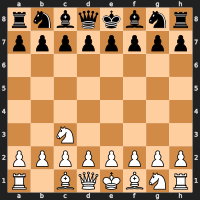

In [7]:
video_path = 'Chess_Data\\chess_new_hard_2.mp4'
if "easy" in video_path or "medium" in video_path:
    if "new_easy_2" in video_path:
        print(video_path)
        chess_track(video_path, 17)
    elif "new_medium_3" in video_path:
        print(video_path)
        chess_track(video_path, 15)
    else:
        print(video_path)
        chess_track(video_path)
        
if "hard" in video_path:  
    print(video_path) 
    chess_track(video_path, continuous_calibration=True, frames_per_move=10, update_mask_thresholds=True)

# Algorithms with bonus annotations and video saving capabilities

These functions are separate due to the impact on the speed of video and are used only for the final saving

In [20]:
def detect_moves2(prev_color_state, new_color_state, chessboard_state, white_turn, board, total_white_figures, total_black_figures, events_queue, show_board=True):
    spaces_alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
    disappeared = []
    appeared = []
    attacked = []
    reduce_white = False
    reduce_black = False
    for i in range(len(prev_color_state)):
        for j in range(len(prev_color_state)):
            # No change
            if prev_color_state[i][j] == new_color_state[i][j]:
                continue
            
            # Figure appeared on empty square
            elif prev_color_state[i][j] == 0:
                appeared.append(spaces_alphabet[j]+str(i))

            # Figure left a square
            elif new_color_state[i][j] == 0:
                disappeared.append(spaces_alphabet[j]+str(i))

            # White figure is attacked
            elif prev_color_state[i][j] == -1:
                attacked.append(spaces_alphabet[j]+str(i))
                reduce_white = True
                # print("Attack on white")
    
            # Black figure is attacked
            elif prev_color_state[i][j] == 1:
                attacked.append(spaces_alphabet[j]+str(i))
                reduce_black = True
                # print("Attack on black")

    move_str = None
    svg_board = None
    # if len(disappeared) > 0 or len(appeared) > 0 or len(attacked) > 0:
        # print(disappeared, appeared, attacked)

    small_board_size = 600
    if len(attacked) > 0:
        for dis in disappeared:
            for att in attacked:
                move_str = dis[0] + str(int(dis[1])+1) + att[0] + str(int(att[1])+1)
                try:
                    move = chess.Move.from_uci(move_str)
                    if move in board.legal_moves:

                        board.push(move)
                        fig = chessboard_state[int(dis[1])][spaces_alphabet.index(dis[0])]
                        fig2 = chessboard_state[int(att[1])][spaces_alphabet.index(att[0])]

                        chessboard_state[int(dis[1])][spaces_alphabet.index(dis[0])] = ""
                        chessboard_state[int(att[1])][spaces_alphabet.index(att[0])] = fig

                        prev_color_state[int(dis[1])][spaces_alphabet.index(dis[0])] = 0
                        prev_color_state[int(att[1])][spaces_alphabet.index(att[0])] = -1 if fig[0].isupper() else 1

                        svg_board = chess.svg.board(board=board, size=small_board_size)

                        if show_board:
                            display(svg_board)

                        if reduce_white:
                            total_white_figures -= 1

                        if reduce_black:
                            total_black_figures -= 1
                        
                        events_queue.append([f"{fig} captures {fig2}", 60])

                        return chessboard_state, prev_color_state, not white_turn, True, total_white_figures, total_black_figures, events_queue, svg_board
                        
                except AssertionError as e:
                    pass

        move_str = None

    elif len(appeared) == 1 and len(disappeared) == 1:
        move_from = disappeared[0]
        move_to = appeared[0]
        
        new_move_from = move_from[0] + str(int(move_from[1])+1)
        new_move_to = move_to[0] + str(int(move_to[1])+1)

        move_str = new_move_from + new_move_to
        # print(move_str)
        try:
            move = chess.Move.from_uci(move_str)
            if move not in board.legal_moves:
                # print(f"Illegal move {move}")
                return chessboard_state, new_color_state, white_turn, False, total_white_figures, total_black_figures, events_queue, svg_board
            
            else:
                board.push(move)
                fig = chessboard_state[int(move_from[1])][spaces_alphabet.index(move_from[0])]
                chessboard_state[int(move_from[1])][spaces_alphabet.index(move_from[0])] = ""
                chessboard_state[int(move_to[1])][spaces_alphabet.index(move_to[0])] = fig

                prev_color_state[int(move_from[1])][spaces_alphabet.index(move_from[0])] = 0
                prev_color_state[int(move_to[1])][spaces_alphabet.index(move_to[0])] = -1 if fig[0].isupper() else 1

                events_queue.append([f"{fig} {new_move_to}", 60])
                
                svg_board = chess.svg.board(board=board, size=small_board_size)
                if show_board:
                    display(svg_board)

                return chessboard_state, prev_color_state, not white_turn, True, total_white_figures, total_black_figures, events_queue, svg_board
            
        except AssertionError as e:
            pass
        
        move_str = None

    # Detect castling
    elif 'e7' in disappeared:
        # King side castle
        if 'h7' in disappeared:
            castle_king_rook = ['b', [4,6], [7,5]]
            move_str = 'e8g8'
            # print(move_str)
            events_queue.append([f"Black king-side castle", 120])

        # Queen side castle
        elif 'a7' in disappeared:
            castle_king_rook = ['b', [4,2], [0,3]]
            move_str = 'e8c8'
            # print(move_str)
            events_queue.append([f"Black queen-side castle", 120])

    elif 'e0' in disappeared:
        # King side castle
        if 'h0' in disappeared:
            castle_king_rook = ['w', [4,6], [7,5]]
            move_str = 'e1g1'
            # print(move_str)
            events_queue.append([f"White king-side castle", 120])

        # Queen side castle
        elif 'a0' in disappeared:
            castle_king_rook = ['w', [4,2], [0,3]]
            move_str = 'e1c1'
            # print(move_str)
            events_queue.append([f"White queen-side castle", 120])

    if move_str is not None:
        move = chess.Move.from_uci(move_str)
        if move not in board.legal_moves:
            events_queue.pop() # Remove last element
            pass
            # print(f"Illegal move {move}")
        else:
            board.push(move)
            row = 0 if castle_king_rook[0] == 'w' else 7
            
            # Correct chessboard state
            chessboard_state[row][castle_king_rook[1][0]] = ""
            chessboard_state[row][castle_king_rook[2][0]] = ""
            chessboard_state[row][castle_king_rook[1][1]] = "king" if row == 7 else "King"
            chessboard_state[row][castle_king_rook[2][1]] = "rook" if row == 7 else "Rook"

            # Make sure color state is correct
            prev_color_state[row][castle_king_rook[1][0]] = 0
            prev_color_state[row][castle_king_rook[2][0]] = 0
            prev_color_state[row][castle_king_rook[1][1]] = 1 if row == 7 else -1
            prev_color_state[row][castle_king_rook[2][1]] = 1 if row == 7 else -1

            svg_board = chess.svg.board(board=board, size=small_board_size)
            if show_board:
                display(svg_board)

            return chessboard_state, prev_color_state, not white_turn, True, total_white_figures, total_black_figures, events_queue, svg_board
            
    return chessboard_state, prev_color_state, white_turn, False, total_white_figures, total_black_figures, events_queue, svg_board

In [21]:
def chess_track_save(video_path, frames_per_move=5, distance_threshold=7, continuous_calibration=False, update_mask_thresholds=False):
    events_queue = []
    # White on top for easier indexing
    prev_chessboard_state = [
        ['Rook', 'Knight', 'Bishop', 'Queen', 'King', 'Bishop', 'Knight', 'Rook'],
        ['Pawn', 'Pawn', 'Pawn', 'Pawn', 'Pawn', 'Pawn', 'Pawn', 'Pawn'],
        ['', '', '', '', '', '', '', ''],
        ['', '', '', '', '', '', '', ''],
        ['', '', '', '', '', '', '', ''],
        ['', '', '', '', '', '', '', ''],
        ['pawn', 'pawn', 'pawn', 'pawn', 'pawn', 'pawn', 'pawn', 'pawn'],
        ['rook', 'knight', 'bishop', 'queen', 'king', 'bishop', 'knight', 'rook']
    ]
    new_chessboard_state = prev_chessboard_state.copy()

    # -1: white, 0: empty, 1: black
    new_color_state = [
        [-1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1]
    ]
    prev_color_state = new_color_state.copy()

    # Decrease after figure of color eliminated
    total_black_figures = 16
    total_white_figures = 16

    white_turn = True
    is_first_frame = True
    frame_number = 0

    target_square_size = 1000  # Adjust the size as needed
    target_points = np.array([[0, 0], [0, target_square_size - 1], [target_square_size - 1, 0], [target_square_size - 1, target_square_size - 1]], dtype=np.float32)
    
    display_hand = 0
    save_filename = f"tracked_{video_path[17:-4]}.avi"
    
    out = cv2.VideoWriter(save_filename, cv2.VideoWriter_fourcc(*'XVID'), 20, (800,500))

    video_capture = cv2.VideoCapture(video_path)
    board = chess.Board()
    prev_svg_board = chess.svg.board(board=board, size=600)
    new_svg_board = None
    new_chessboard_state = prev_chessboard_state.copy()
    while True:
        ret, frame = video_capture.read()
        if not ret:
            break

        if continuous_calibration:
            closest_corners = get_closest_corners(frame)

            if is_first_frame:
                ref_corners = closest_corners.copy()
                is_first_frame = False

            # If change in corners is big, use last accepted reference corners
            distances = get_corner_diff(ref_corners, closest_corners)

            marked_change = [False, False, False, False]
            for c in range(4):
                if distances[c] > distance_threshold:
                    marked_change[c] = True

            corrected_corners = correct_corners(closest_corners, ref_corners, marked_change)
            ref_corners = corrected_corners.copy()

            homography_matrix, _ = cv2.findHomography(corrected_corners[:,::-1], target_points)

        else:
            if is_first_frame:
                closest_corners = get_closest_corners(frame)
                homography_matrix, _ = cv2.findHomography(closest_corners[:,::-1], target_points)
                is_first_frame = False

        # Apply the perspective transformation
        calibrated_image = cv2.warpPerspective(frame, homography_matrix, (target_square_size, target_square_size))
        # Flip board to correct chessboard indexes
        calibrated_image = cv2.flip(calibrated_image, 1)

        grid_img = calibrated_image.copy()
        offset = 59 # Board edge offset
        grid_division = np.linspace(offset, target_square_size-offset, 9, dtype=int)
        for x in grid_division:
            cv2.line(grid_img, (x, 0+offset), (x, target_square_size-offset), color=(0, 0, 255), thickness=2)  
            cv2.line(grid_img, (0+offset, x), (target_square_size-offset, x), color=(0, 0, 255), thickness=2)  

        # Display the result
        # cv2.imshow('Chessboard focus', grid_img)
            
        calibrated_frame = calibrated_image.copy()

        if frame_number%frames_per_move == 0:
            new_color_state = get_board_color_state(calibrated_frame, grid_division, total_white_figures, total_black_figures, update_mask_thresholds)
            if new_color_state is not None:
                # for x in new_color_state:
                #     print(x)

                # imshow(image)

                new_chessboard_state, new_color_state, white_turn, new_move, total_white_figures, total_black_figures, events_queue, new_svg_board = detect_moves2(prev_color_state, \
                                                                                                                                     new_color_state, \
                                                                                                                                     prev_chessboard_state, \
                                                                                                                                     white_turn, \
                                                                                                                                     board, \
                                                                                                                                     total_white_figures, \
                                                                                                                                     total_black_figures,\
                                                                                                                                     events_queue, show_board=False)
                if new_move:
                    prev_color_state = new_color_state
            else:
                display_hand = frames_per_move+2

        if display_hand > 0:
            display_hand -= 1

        if new_svg_board is not None:
            prev_svg_board = new_svg_board

        display_moves(calibrated_frame, new_chessboard_state, grid_division)
        height, width, channels = calibrated_frame.shape

        event_space_width = 600
        # Create a new canvas with extended width
        new_width = width + event_space_width
        new_image = np.zeros((height, new_width, channels), dtype=np.uint8)

        # Copy the original image to the left side of the new canvas
        new_image[:, :width, :] = calibrated_frame

        cv2.putText(new_image, f'Score:', (1010, 320), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        cv2.putText(new_image, f'White: {16-total_black_figures}   Black: {16-total_white_figures}', (1010, 370), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

        display_events(new_image, events_queue, display_hand)
        prev_chessboard_state = new_chessboard_state.copy()
        
        png_data = cairosvg.svg2png(bytestring=prev_svg_board)
        
        new_image = Image.fromarray(new_image)
        chessboard_image = Image.open(io.BytesIO(png_data))

        new_image.paste(chessboard_image, (1000, 400), chessboard_image)

        new_image = np.asarray(new_image)
        out.write(cv2.resize(new_image, (800, 500)))
        # out.write(new_image)
        cv2.imshow("Figure Detection", new_image)

        frame_number+=1

        # Display the result    
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    out.release()   
    video_capture.release()
    cv2.destroyAllWindows()

    # Move the file to the subfolder
    destination_path = os.path.join("chess_save", save_filename)
    shutil.move(save_filename, destination_path)

In [22]:
# video_path = 'Chess_Data\\chess_new_easy_1.mp4'

# if not os.path.exists("chess_save"):
#     os.makedirs("chess_save")

# if "easy" in video_path or "medium" in video_path:
#     if "3" in video_path:
#         chess_track_save(video_path, 15, save_video=True)
#     else:
#         chess_track_save(video_path)
# if "hard" in video_path:
#     chess_track_save(video_path, continuous_calibration=True, frames_per_move=10, upper_blue_threshold=120, save_video=True)

In [25]:
# # Automate saving

# folder_path = 'Chess_Data'  # Replace with the actual folder path

# # Iterate through each file in the folder
# for filename in os.listdir(folder_path):
#     video_path = os.path.join(folder_path, filename)

#     # Check if the path is a file (not a subfolder)
#     if os.path.isfile(video_path):
#         if "easy" in video_path or "medium" in video_path:
#             if "new_easy_2" in video_path:
#                 print(video_path)
#                 chess_track_save(video_path, 17)
#             elif "new_medium_3" in video_path:
#                 print(video_path)
#                 chess_track_save(video_path, 15)
#             else:
#                 print(video_path)
#                 chess_track_save(video_path)
                
#         if "hard" in video_path:  
#             print(video_path) 
#             chess_track_save(video_path, continuous_calibration=True, frames_per_move=10, update_mask_thresholds=True)

Chess_Data\chess_new_easy_1.mp4
Chess_Data\chess_new_easy_2.mp4
Chess_Data\chess_new_easy_3.mp4
Chess_Data\chess_new_hard_1.mp4
Chess_Data\chess_new_hard_2.mp4
Chess_Data\chess_new_hard_3.mp4
Chess_Data\chess_new_medium_1.mp4
Chess_Data\chess_new_medium_2.mp4
Chess_Data\chess_new_medium_3.mp4
